In [115]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
from scipy import stats
import re

# Data

## Read in data

In [9]:
products = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/products_train.csv')
sessions = pd.read_csv('/content/drive/MyDrive/SocialNetworkAnalysis-2024Spring/Final Project/data/sessions_train.csv')

### Overview of data

In [10]:
products.head()

# IDEA 1:
# Only consider data in English

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [11]:
sessions.head()

# IDEA 2:
# 1. Only consider sessions in English
# 2. Only consider sessions that has more than certain number of items

,prev_items,next_item,locale
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE


In [12]:
products.info()

# IDEA 3:
# !!!1. Keep items that has brand & the number of items in that brand is large (how larg, we might decide it later)
# !!!2. Since not too many items do not have color, so we might want to filter out items that does not have color
#       & maybe filter out colors that are not having many items in it
# !!!3. I think material is important for categories, will check it later then decide whether use it
# !!!4. desc, need take a close look => giving strategies to deal with it
# !! 5. Many missing values in size, we can consider whether use size after filter the brand and color
# !  6. Model, not sure how it works, but it probably is more detailed info for that brand
#    7. Only miss 8 titles, not a big deal and it might be filtered out after previous steps
#    8. Author, too many missing value, NOT CONSIDER USING IT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551057 entries, 0 to 1551056
Data columns (total 11 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   id        1551057 non-null  object 
 1   locale    1551057 non-null  object 
 2   title     1551049 non-null  object 
 3   price     1551057 non-null  float64
 4   brand     1531691 non-null  object 
 5   color     1125432 non-null  object 
 6   size      917091 non-null   object 
 7   model     761137 non-null   object 
 8   material  834382 non-null   object 
 9   author    73509 non-null    object 
 10  desc      1424083 non-null  object 
dtypes: float64(1), object(10)
memory usage: 130.2+ MB


In [13]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606249 entries, 0 to 3606248
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   prev_items  object
 1   next_item   object
 2   locale      object
dtypes: object(3)
memory usage: 82.5+ MB


### Detail look of data

#### products

In [14]:
products.columns

Index(['id', 'locale', 'title', 'price', 'brand', 'color', 'size', 'model',
       'material', 'author', 'desc'],
      dtype='object')

##### locale

In [15]:
products['locale'].value_counts()

# TODO 1:
# Filter both products and sessions only for UK

DE    518327
UK    500180
JP    395009
IT     50461
FR     44577
ES     42503
Name: locale, dtype: int64

##### price

In [17]:
products['price'].describe()

# TODO 2:
# Filter out those items that are too expensive, only keep price < 100 ?

count    1.551057e+06
mean     1.806107e+06
std      8.302930e+06
min      0.000000e+00
25%      1.119000e+01
50%      2.328000e+01
75%      7.990000e+02
max      4.000000e+07
Name: price, dtype: float64

(array([1481065.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   69992.]),
 array([       0.   ,  4000000.007,  8000000.014, 12000000.021,
        16000000.028, 20000000.035, 24000000.042, 28000000.049,
        32000000.056, 36000000.063, 40000000.07 ]),
 <BarContainer object of 10 artists>)

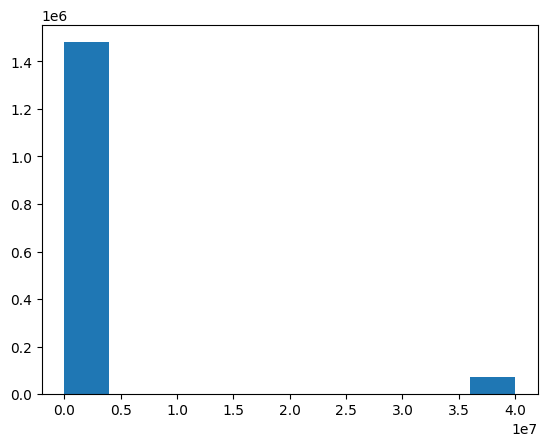

In [18]:
plt.hist(products['price'])

(array([1.481029e+06, 3.000000e+01, 5.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([      0.,  393380.,  786760., 1180140., 1573520., 1966900.,
        2360280., 2753660., 3147040., 3540420., 3933800.]),
 <BarContainer object of 10 artists>)

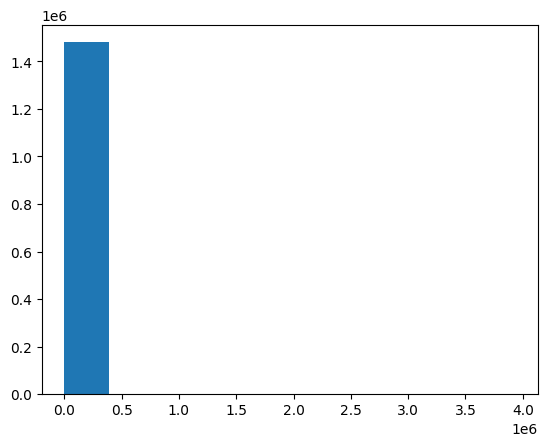

In [19]:
plt.hist(products.loc[products['price']<5000000]['price'])

(array([1.477611e+06, 2.233000e+03, 6.280000e+02, 2.990000e+02,
        1.370000e+02, 6.100000e+01, 3.800000e+01, 2.200000e+01,
        1.200000e+01, 9.000000e+00]),
 array([     0. ,  49087.1,  98174.2, 147261.3, 196348.4, 245435.5,
        294522.6, 343609.7, 392696.8, 441783.9, 490871. ]),
 <BarContainer object of 10 artists>)

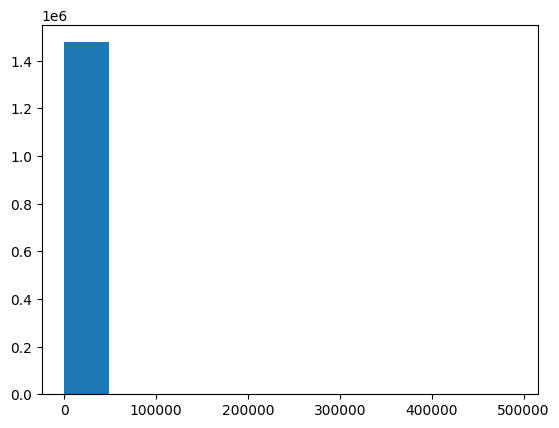

In [20]:
plt.hist(products.loc[products['price']<500000]['price'])

(array([1.452752e+06, 1.612800e+04, 4.994000e+03, 2.547000e+03,
        1.371000e+03, 8.060000e+02, 5.080000e+02, 3.500000e+02,
        2.370000e+02, 2.080000e+02]),
 array([    0. ,  9997.6, 19995.2, 29992.8, 39990.4, 49988. , 59985.6,
        69983.2, 79980.8, 89978.4, 99976. ]),
 <BarContainer object of 10 artists>)

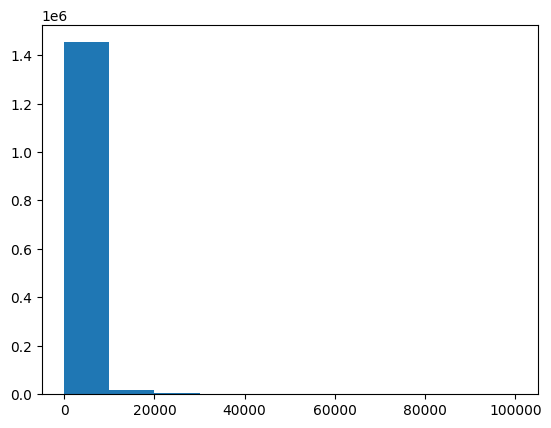

In [21]:
plt.hist(products.loc[products['price']<100000]['price'])

(array([1308260.,   95326.,   27958.,   13289.,    8165.,    4538.,
           3950.,    3123.,    2281.,    2070.]),
 array([    0. ,  1999.9,  3999.8,  5999.7,  7999.6,  9999.5, 11999.4,
        13999.3, 15999.2, 17999.1, 19999. ]),
 <BarContainer object of 10 artists>)

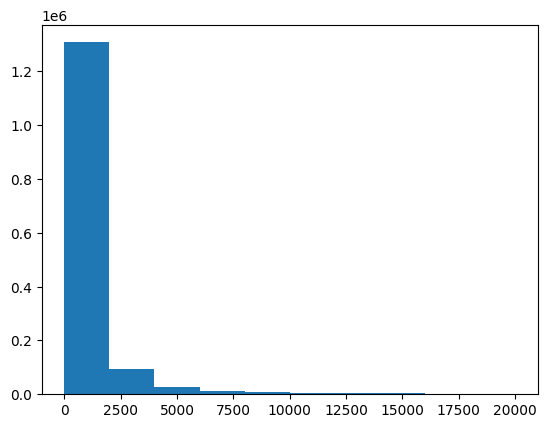

In [22]:
plt.hist(products.loc[products['price']<20000]['price'])

(array([1091018.,   30456.,   34677.,   41574.,   25548.,   32869.,
          25119.,   27003.,   15548.,   16384.]),
 array([   0.   ,  249.999,  499.998,  749.997,  999.996, 1249.995,
        1499.994, 1749.993, 1999.992, 2249.991, 2499.99 ]),
 <BarContainer object of 10 artists>)

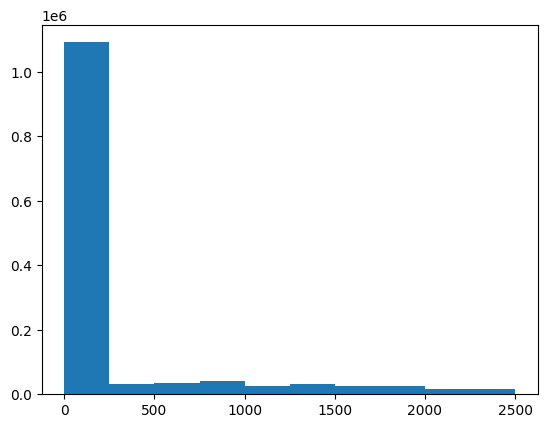

In [24]:
plt.hist(products.loc[products['price']<2500]['price'])

(array([993147.,  61076.,  19010.,  11163.,   6622.,   6334.,   5708.,
          5913.,   5644.,   6857.]),
 array([  0.   ,  49.999,  99.998, 149.997, 199.996, 249.995, 299.994,
        349.993, 399.992, 449.991, 499.99 ]),
 <BarContainer object of 10 artists>)

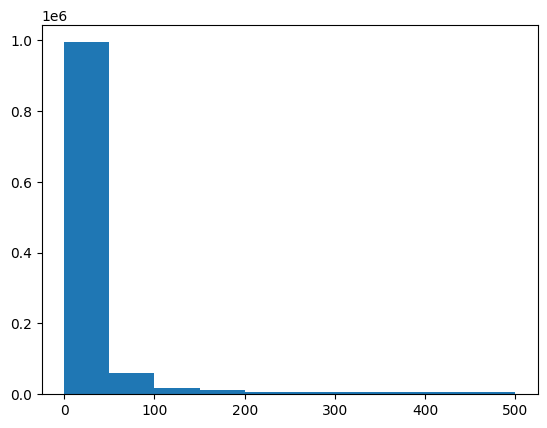

In [25]:
plt.hist(products.loc[products['price']<500]['price'])

(array([348514., 372895., 161198.,  74944.,  35596.,  21398.,  14255.,
         10387.,   8028.,   7008.]),
 array([ 0.   ,  9.999, 19.998, 29.997, 39.996, 49.995, 59.994, 69.993,
        79.992, 89.991, 99.99 ]),
 <BarContainer object of 10 artists>)

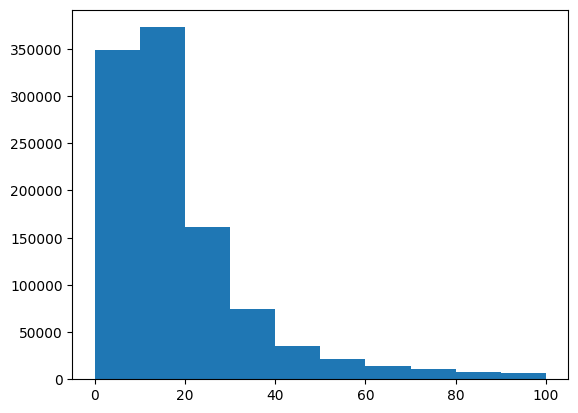

In [28]:
plt.hist(products.loc[products['price']<100]['price'])

##### brand

In [31]:
brand_counts = products['brand'].value_counts()
brand_counts # 178776 brands

# TODO 3:
# Filter out rare brands

Amazon Basics              5018
LEGO                       3953
Apple                      3930
Independently published    3421
Generic                    3355
                           ... 
THE SINGLETON(ザ・シングルトン)       1
シービーエム.ビー.ヴイ (CBM.B.V.)       1
Tops                          1
yokoso                        1
Ymea                          1
Name: brand, Length: 178776, dtype: int64

In [32]:
brand_counts[brand_counts > 100] # 1792

Amazon Basics                  5018
LEGO                           3953
Apple                          3930
Independently published        3421
Generic                        3355
                               ... 
Foluu                           101
Smartwares                      101
GRÄFE UND UNZER Verlag GmbH     101
Medi Partners                   101
Jonwelsy                        101
Name: brand, Length: 1792, dtype: int64

In [33]:
brand_counts[brand_counts > 500] # 139

Amazon Basics              5018
LEGO                       3953
Apple                      3930
Independently published    3421
Generic                    3355
                           ... 
Brennenstuhl                508
マキタ(Makita)                 508
Faber-Castell               508
Clementoni                  507
Amazon EU S.à.r.l.          506
Name: brand, Length: 139, dtype: int64

In [41]:
len(brand_counts[brand_counts > 1000]) # 48

48

##### color

In [43]:
color_counts = products['color'].value_counts()
color_counts # 219994

# TODO 5:
# Filter out rare colors.

Black                    64182
Schwarz                  48778
White                    39198
ブラック                     32102
Weiß                     28075
                         ...  
#b1.K1 青黄                    1
4K 60Hz 1x2 HDMI 分配器         1
竹（支柱付きのスクエアフレキシブル化粧鏡）        1
杢調 ブラウン                      1
6 Pezzi.                     1
Name: color, Length: 219994, dtype: int64

In [45]:
len(color_counts[color_counts > 10000])

14

##### size

In [49]:
sum(products['size'].notnull())

917091

In [59]:
size_notnull = products.loc[products['size'].notnull()]
size_notnull_counts = size_notnull['size'].value_counts()
size_notnull_counts

# TODO 6:
# filter some size out

One Size                  19599
1 Count (Pack of 1)       14772
1 Stück (1er Pack)        13739
M                         13471
L                         13041
                          ...  
12800u                        1
③4個                           1
幅15.5×奥行き15.5×高さ49(cm)        1
For iPhone 12mini             1
6 Pezzi (2L + 2M + 2S)        1
Name: size, Length: 231617, dtype: int64

In [61]:
len(size_notnull_counts[size_notnull_counts > 1000])

63

In [62]:
len(size_notnull_counts[size_notnull_counts > 10000])

6

##### model

In [68]:
sum(products['size'].notnull())

# TODO 7:
# filter some model out

917091

In [66]:
model_notnull = products.loc[products['model'].notnull()]
model_notnull_counts = model_notnull['model'].value_counts()
model_notnull_counts

1                    6215
.                    4445
-                    1888
0                     803
AK3-AT1-GL-M-X        763
                     ... 
A7712-1                 1
4946324037789           1
11166                   1
MCP-8050R(OW/SWH)       1
C4493900                1
Name: model, Length: 524217, dtype: int64

In [67]:
len(model_notnull_counts[model_notnull_counts > 100])

45

##### material

In [74]:
sum(products['material'].notnull())

# TODO 8:
# filter some materials out

834382

In [70]:
material_notnull = products.loc[products['material'].notnull()]
material_notnull_counts = material_notnull['material'].value_counts()
material_notnull_counts

Plastic                                   43464
Kunststoff                                41180
Polyester                                 25525
Edelstahl                                 17246
Aluminium                                 16870
                                          ...  
天然ゴム系粘着剤、ポリエステル/ポリウレタン不織布基材                   1
すっぽん                                          1
本体・中フタ=ポリプロピレン 上フタ=ポリエチレン パッキン=シリコーン樹脂        1
スチールフレーム                                      1
Polietilene Ppa                               1
Name: material, Length: 49613, dtype: int64

In [72]:
len(material_notnull_counts[material_notnull_counts > 10000])

13

##### author

In [75]:
sum(products['author'].notnull())

# TODO 9:
# delete author column

73509

##### desc

In [78]:
sum(products['desc'].notnull())

1424083

In [92]:
desc_uk_notnull = products.loc[(products['locale'] == 'UK') & (products['desc'].notnull())]['desc']

In [97]:
desc_uk_notnull

913336     COLOR: The sherpa throw blanket is available i...
913337                                  Competitively priced
913339     【AFTER-SALE】This handheld food heat sealer sho...
913340     🔐【 Anti-Friction & Customer First】Each box of ...
913341                                                Horror
                                 ...                        
1413508    Boing rope included: This bird cage comes with...
1413509    Easy to clean ✓ The toilet seat has a special ...
1413510    CONVENIENT: Can be hung from a branch or feedi...
1413514    Added Protection: An additional layer of prote...
1413515    🔵 Mini Pegs : 100 Wooden Pegs For Decoration, ...
Name: desc, Length: 460922, dtype: object

In [99]:
desc_uk_notnull[913336]

'COLOR: The sherpa throw blanket is available in a variety of colors, being able to meet your individual requirements. With different colors to choose from, you will easily find the suitable throw blanket to coordinate with your decor.'

In [100]:
desc_uk_notnull[913340]

'🔐【 Anti-Friction & Customer First】Each box of products is equipped with anti-friction lining strips which avoids scratches on the steering wheel during use. Lucosobie must be responsible for any product defects and provides the car steering wheel lock 12-MONTH warranty. It is not just lip service!'

#### sessions

In [103]:
sessions.columns

# TODO 10:
# filter sessions in "UK"

Index(['prev_items', 'next_item', 'locale'], dtype='object')

In [120]:
prev_len = list(map(lambda row: len(row.strip('[]').split()), sessions['prev_items']))
sessions['prev_items_len'] = prev_len
sessions.head()

,prev_items,next_item,locale,prev_items_len
0,['B09W9FND7K' 'B09JSPLN1M'],B09M7GY217,DE,2
1,['B076THCGSG' 'B007MO8IME' 'B08MF65MLV' 'B001B...,B001B4THSA,DE,4
2,['B0B1LGXWDS' 'B00AZYORS2' 'B0B1LGXWDS' 'B00AZ...,B0767DTG2Q,DE,9
3,['B09XMTWDVT' 'B0B4MZZ8MB' 'B0B7HZ2GWX' 'B09XM...,B0B4R9NN4B,DE,7
4,['B09Y5CSL3T' 'B09Y5DPTXN' 'B09FKD61R8'],B0BGVBKWGZ,DE,3


In [122]:
sessions['prev_items_len'].describe()

count    3.606249e+06
mean     4.244350e+00
std      3.548881e+00
min      2.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      4.740000e+02
Name: prev_items_len, dtype: float64

(array([3.605555e+06, 6.360000e+02, 4.700000e+01, 7.000000e+00,
        2.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([  2. ,  49.2,  96.4, 143.6, 190.8, 238. , 285.2, 332.4, 379.6,
        426.8, 474. ]),
 <BarContainer object of 10 artists>)

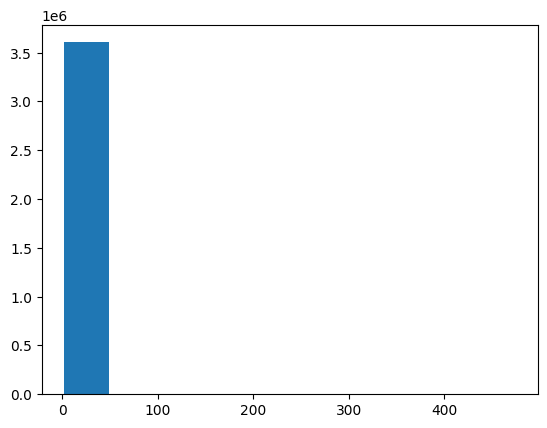

In [123]:
plt.hist(sessions['prev_items_len'])

(array([3.458839e+06, 1.275480e+05, 1.551900e+04, 2.802000e+03,
        8.990000e+02, 3.130000e+02, 1.160000e+02, 8.600000e+01,
        4.700000e+01, 3.100000e+01]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <BarContainer object of 10 artists>)

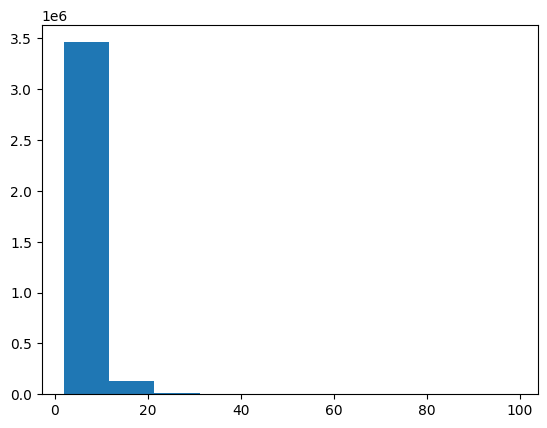

In [124]:
plt.hist(sessions.loc[sessions['prev_items_len']<100]['prev_items_len'])

(array([2.85519e+06, 5.10487e+05, 1.47302e+05, 4.35780e+04, 2.61090e+04,
        1.15280e+04, 4.41500e+03, 3.29700e+03, 1.67000e+03, 9.83000e+02]),
 array([ 2. ,  5.7,  9.4, 13.1, 16.8, 20.5, 24.2, 27.9, 31.6, 35.3, 39. ]),
 <BarContainer object of 10 artists>)

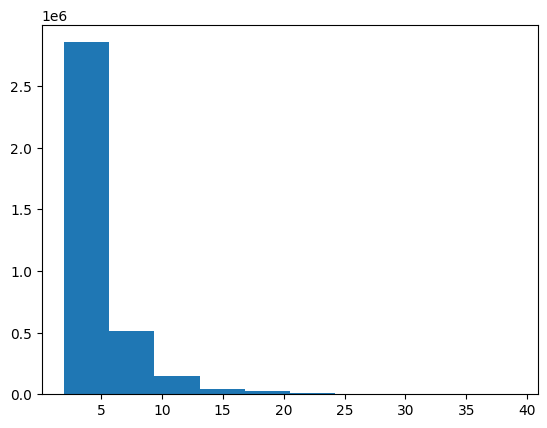

In [125]:
plt.hist(sessions.loc[sessions['prev_items_len']<40]['prev_items_len'])

(array([2096284.,  758906.,  338913.,   99305.,  125576.,   70507.,
          23488.,   32412.,   19990.,   12612.]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ]),
 <BarContainer object of 10 artists>)

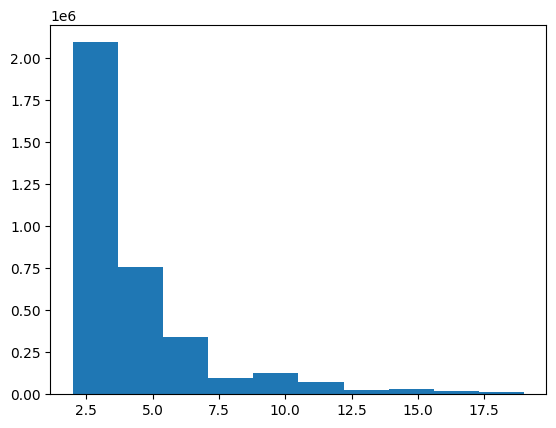

In [126]:
plt.hist(sessions.loc[sessions['prev_items_len']<20]['prev_items_len'])

# Data Cleaning

## Filter

to keep target rows

### filter locale

In [127]:
products_uk = products.loc[products['locale']=='UK']
products_uk.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
913336,B087LZNPHS,UK,"SOCHOW Sherpa Fleece Throw Blanket, Double-Sid...",24.99,SOCHOW,Teal Green,127cm×150cm,NaN,100% Polyester,NaN,COLOR: The sherpa throw blanket is available i...
913337,B08THFN1KX,UK,Hippowarehouse Personalised Photo Printed Mous...,9.95,Hippowarehouse,White,240mm x 190mm x 60mm,50245-Mat-Perso,Rubber,NaN,Competitively priced
913338,0804185328,UK,"500 Easy Recipes for Every Machine, Both Stove...",16.49,Clarkson Potter,White,NaN,NaN,NaN,"Scarbrough, Mark",NaN
913339,B09VBKDBW6,UK,"TYHJOY Mini Bag Sealer, Handheld Vacuum Heat S...",11.99,TYHJOY,Black,NaN,FBA-sealer-black,Acrylonitrile Butadiene Styrene,NaN,【AFTER-SALE】This handheld food heat sealer sho...
913340,B096ZW8B49,UK,Lucosobie Steering Wheel Lock - Car Anti-Theft...,26.99,Lucosobie,Black,NaN,NaN,Alloy Steel,NaN,🔐【 Anti-Friction & Customer First】Each box of ...


In [128]:
sessions_uk = sessions.loc[sessions['locale'] == 'UK']
sessions_uk.head()

,prev_items,next_item,locale,prev_items_len
2090535,['B0BFDL54Y7' 'B0BFDR9X13' 'B07J4WF8VH' 'B07Y2...,B07Y227WNJ,UK,4
2090536,['B07FM2GLNQ' 'B07GZW3P4W'],B095NNZCR6,UK,2
2090537,['B0021L95HU' 'B07DDL77RY' 'B07DDL77RY'],B002KA1FZC,UK,3
2090538,['B0B2WSZYL2' 'B000I8XZ7O'],B000I90TAO,UK,2
2090539,['B00LW1APOC' 'B00LW1APOC' 'B00OI6NQUI' 'B09HL...,B07H54NZ3K,UK,4


In [130]:
products_uk.shape

(500180, 11)

In [131]:
sessions_uk.shape

(1182181, 4)

### filter price

(array([474900.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  25280.]),
 array([       0.   ,  4000000.007,  8000000.014, 12000000.021,
        16000000.028, 20000000.035, 24000000.042, 28000000.049,
        32000000.056, 36000000.063, 40000000.07 ]),
 <BarContainer object of 10 artists>)

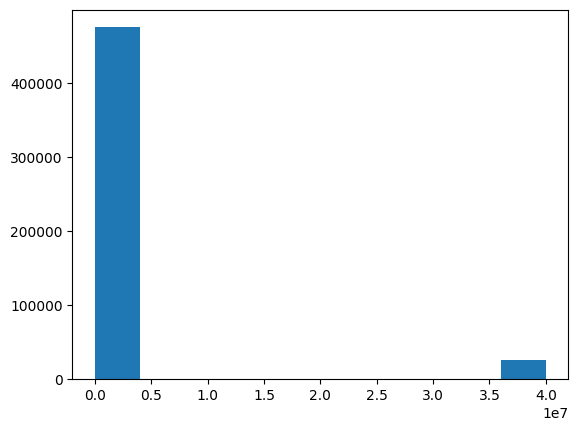

In [132]:
plt.hist(products_uk['price'])

If we take the limit for "price", there will be -38230 rows filtered out.
Number of rows are left:  461950



(array([193735., 157368.,  59807.,  23295.,  10546.,   6000.,   4048.,
          2872.,   2297.,   1982.]),
 array([ 0.   ,  9.999, 19.998, 29.997, 39.996, 49.995, 59.994, 69.993,
        79.992, 89.991, 99.99 ]),
 <BarContainer object of 10 artists>)

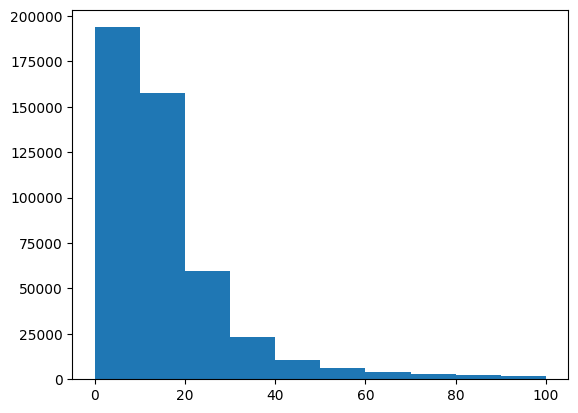

In [165]:
del_rows_num = len(products_uk.loc[products_uk['price']<100]['price']) - products_uk.shape[0]
print(f'If we take the limit for "price", there will be {del_rows_num} rows filtered out.')
print(f'Number of rows are left: ', len(products_uk.loc[products_uk['price']<100]['price']))
print()
plt.hist(products_uk.loc[products_uk['price']<100]['price'])

### filter brand

5-10 is good.

In [185]:
sum(products_uk['brand'].notnull())

495900

In [141]:
brand_counts = products_uk['brand'].value_counts()
brand_counts

Generic            2283
L'Oreal            1508
Amazon Basics      1402
LEGO               1335
Morrisons          1287
                   ... 
Bookends2pairUK       1
Lipton Iced Tea       1
Q&K                   1
HULY                  1
CRYSTALS              1
Name: brand, Length: 76349, dtype: int64

In [142]:
brand_counts[brand_counts > 100]

Generic          2283
L'Oreal          1508
Amazon Basics    1402
LEGO             1335
Morrisons        1287
                 ... 
ORETECH           101
Olay              101
Pecute            101
JUSTOTRY          101
POPRUN            101
Name: brand, Length: 439, dtype: int64

In [145]:
brand_counts[brand_counts > 1000]

Generic                    2283
L'Oreal                    1508
Amazon Basics              1402
LEGO                       1335
Morrisons                  1287
Independently published    1191
Apple                      1033
Name: brand, dtype: int64

In [182]:
min_limit = 5

brand_name = brand_counts[brand_counts > min_limit].index.tolist()
brand_value = brand_counts[brand_counts > min_limit].values

print(brand_name)
print(brand_value)
print('Number of brands are included: ', len(brand_name))
print('Number of rows are included: ', sum(brand_value))

['Generic', "L'Oreal", 'Amazon Basics', 'LEGO', 'Morrisons', 'Independently published', 'Apple', 'Samsung', 'Coty', "Smiffy's", 'JETech', 'I LOVE FANCY DRESS LTD', 'Audible', 'Amazon EU Sarl', 'Amazon', 'Coordination Group Publications Ltd (CGP)', 'Philips', 'Anker', 'Spigen', 'Hasbro', 'Eono', 'Bosch', 'Penguin', 'amscan', '3M', 'Russell Hobbs', 'Stuff4', 'KW-Commerce', 'Amscan', 'Vicloon', 'HENBRANDT', 'kuou', "Rubie's", 'Wicked Costumes', 'SONGMICS', 'Ravensburger', 'Newell Brands', 'Oral-B', 'UK Greetings', 'HOMCOM', 'Yaheetech', 'Collins', 'Barbie', 'GC GAVENO CAVAILIA', 'MiniSun', 'Bedshe', 'BLUESKY', 'Logitech', 'Deconovo', 'MYLEE', 'Silentnight', 'VEYLIN', 'Disney', 'Hallmark', 'Garnier', 'Tower', 'Addis', 'Baker Ross', 'Nintendo', 'Mattel', 'Funko', 'Stanley', 'ANSIO', 'HP', 'ORNARTO', 'Melissa & Doug', 'Sleepdown', 'Mayborn Group', 'UGREEN', 'HarperCollins', 'MAM', 'Draper', 'TP-Link', 'MoKo', 'OtterBox', 'JOYIN', 'Brabantia', 'Everbuild', 'Amazon EU S.à.r.l.', 'Playmobil', '

In [168]:
min_limit = 10

brand_name = brand_counts[brand_counts > min_limit].index.tolist()
brand_value = brand_counts[brand_counts > min_limit].values

print(brand_name)
print(brand_value)
print('Number of brands are included: ', len(brand_name))
print('Number of rows are included: ', sum(brand_value))

['Generic', "L'Oreal", 'Amazon Basics', 'LEGO', 'Morrisons', 'Independently published', 'Apple', 'Samsung', 'Coty', "Smiffy's", 'JETech', 'I LOVE FANCY DRESS LTD', 'Audible', 'Amazon EU Sarl', 'Amazon', 'Coordination Group Publications Ltd (CGP)', 'Philips', 'Anker', 'Spigen', 'Hasbro', 'Eono', 'Bosch', 'Penguin', 'amscan', '3M', 'Russell Hobbs', 'Stuff4', 'KW-Commerce', 'Amscan', 'Vicloon', 'HENBRANDT', 'kuou', "Rubie's", 'Wicked Costumes', 'SONGMICS', 'Ravensburger', 'Newell Brands', 'Oral-B', 'UK Greetings', 'HOMCOM', 'Yaheetech', 'Collins', 'Barbie', 'GC GAVENO CAVAILIA', 'MiniSun', 'Bedshe', 'BLUESKY', 'Logitech', 'Deconovo', 'MYLEE', 'Silentnight', 'VEYLIN', 'Disney', 'Hallmark', 'Garnier', 'Tower', 'Addis', 'Baker Ross', 'Nintendo', 'Mattel', 'Funko', 'Stanley', 'ANSIO', 'HP', 'ORNARTO', 'Melissa & Doug', 'Sleepdown', 'Mayborn Group', 'UGREEN', 'HarperCollins', 'MAM', 'Draper', 'TP-Link', 'MoKo', 'OtterBox', 'JOYIN', 'Brabantia', 'Everbuild', 'Amazon EU S.à.r.l.', 'Playmobil', '

### filter color

In [184]:
sum(products_uk['color'].notnull())

378080

In [158]:
color_counts = products_uk['color'].value_counts()
color_counts

Black                         56750
White                         33187
Blue                          15002
Grey                          11594
Silver                        10344
                              ...  
Warm White(3m*2m)                 1
Big Tray + Blue Mat               1
B-bead Dark Pink                  1
Four-Leaf Clover Bowl Blue        1
Deep Grey Yuki                    1
Name: color, Length: 72069, dtype: int64

In [175]:
min_limit = 5

color_name = color_counts[color_counts > min_limit].index.tolist()
color_value = color_counts[color_counts > min_limit].values

print(color_name)
print(color_value)
print('Number of colors are included: ', len(color_name))
print('Number of rows are included: ', sum(color_value))

['Black', 'White', 'Blue', 'Grey', 'Silver', 'Multicolor', 'Red', 'Pink', 'Green', 'Clear', 'Brown', 'Transparent', 'Purple', 'Gold', 'Yellow', 'Orange', 'Beige', 'Multicoloured', 'Multi', 'black', 'Warm White', 'Gray', 'Multicolour', 'Rose Gold', 'Assorted', 'white', 'Navy', 'Dark Grey', 'Cream', 'Natural', 'Navy Blue', 'Chrome', 'Multi-colour', 'A', 'Light Grey', 'Cool White', 'BLACK', 'blue', 'Charcoal', 'Multi-coloured', 'Multi-colored', 'As Shown', 'Rainbow', 'Light Blue', 'Stainless Steel', 'Dark Blue', 'Mixed', 'Other', 'Ivory', 'Multicolored', 'transparent', 'Dark Green', 'Teal', 'WHITE', 'Colorful', '1', 'red', 'Dark Brown', 'B', 'Rose', 'clear', 'Various', 'pink', 'silver', 'Light Brown', 'Matte Black', 'grey', 'Burgundy', 'Bronze', 'Turquoise', 'Wood', 'Copper', 'green', 'brown', 'Graphite', 'Coffee', 'Silver Grey', 'Sky Blue', 'Blush Pink', 'multicolor', 'Multi Coloured', 'Black/White', 'Aqua', 'Khaki', 'Assorted Colours', 'Sliver', 'Baby Pink', 'Colourful', 'multicoloured'

In [176]:
min_limit = 100

color_name = color_counts[color_counts > min_limit].index.tolist()
color_value = color_counts[color_counts > min_limit].values

print(color_name)
print(color_value)
print('Number of colors are included: ', len(color_name))
print('Number of rows are included: ', sum(color_value))

['Black', 'White', 'Blue', 'Grey', 'Silver', 'Multicolor', 'Red', 'Pink', 'Green', 'Clear', 'Brown', 'Transparent', 'Purple', 'Gold', 'Yellow', 'Orange', 'Beige', 'Multicoloured', 'Multi', 'black', 'Warm White', 'Gray', 'Multicolour', 'Rose Gold', 'Assorted', 'white', 'Navy', 'Dark Grey', 'Cream', 'Natural', 'Navy Blue', 'Chrome', 'Multi-colour', 'A', 'Light Grey', 'Cool White', 'BLACK', 'blue', 'Charcoal', 'Multi-coloured', 'Multi-colored', 'As Shown', 'Rainbow', 'Light Blue', 'Stainless Steel', 'Dark Blue', 'Mixed', 'Other', 'Ivory', 'Multicolored', 'transparent', 'Dark Green', 'Teal', 'WHITE', 'Colorful', '1', 'red', 'Dark Brown', 'B', 'Rose', 'clear', 'Various', 'pink', 'silver', 'Light Brown', 'Matte Black', 'grey', 'Burgundy', 'Bronze', 'Turquoise', 'Wood', 'Copper', 'green', 'brown', 'Graphite', 'Coffee', 'Silver Grey', 'Sky Blue', 'Blush Pink', 'multicolor', 'Multi Coloured', 'Black/White', 'Aqua', 'Khaki', 'Assorted Colours', 'Sliver', 'Baby Pink', 'Colourful', 'multicoloured'

In [177]:
min_limit = 500

color_name = color_counts[color_counts > min_limit].index.tolist()
color_value = color_counts[color_counts > min_limit].values

print(color_name)
print(color_value)
print('Number of colors are included: ', len(color_name))
print('Number of rows are included: ', sum(color_value))

['Black', 'White', 'Blue', 'Grey', 'Silver', 'Multicolor', 'Red', 'Pink', 'Green', 'Clear', 'Brown', 'Transparent', 'Purple', 'Gold', 'Yellow', 'Orange', 'Beige', 'Multicoloured', 'Multi', 'black', 'Warm White', 'Gray', 'Multicolour', 'Rose Gold', 'Assorted', 'white', 'Navy', 'Dark Grey', 'Cream', 'Natural', 'Navy Blue', 'Chrome', 'Multi-colour', 'A', 'Light Grey', 'Cool White', 'BLACK', 'blue', 'Charcoal']
[56750 33187 15002 11594 10344 10153  8294  7902  7832  6956  6091  3664
  3512  3294  3053  2716  2605  2569  2148  1973  1836  1642  1376  1301
  1213  1176  1032  1007   960   955   775   756   683   661   648   608
   606   563   507]
Number of colors are included:  39
Number of rows are included:  217944


### filter size

### filter model

### filter material

In [186]:
sum(products_uk['material'].notnull())

298955

In [163]:
material_counts = products_uk['material'].value_counts()
material_counts

Plastic                    42638
Metal                      13343
Polyester                  13080
Stainless Steel            10226
Paper                      10029
                           ...  
Gel, Silicone                  1
Polyester + Magnet             1
essential oil set              1
tissue paper                   1
Aluminium,Plastic,Resin        1
Name: material, Length: 14775, dtype: int64

In [164]:
min_limit = 500

material_name = material_counts[material_counts > min_limit].index.tolist()
material_value = material_counts[material_counts > min_limit].values

print(material_name)
print(material_value)
print('Number of materials are included: ', len(material_name))
print('Number of rows are included: ', sum(material_value))

['Plastic', 'Metal', 'Polyester', 'Stainless Steel', 'Paper', 'Cotton', 'Silicone', 'Wood', 'Aluminium', 'Rubber', 'Glass', 'Nylon', 'Acrylonitrile Butadiene Styrene', 'Alloy Steel', 'Acrylic', 'Faux Leather', 'Cardboard', 'Leather', 'Polypropylene', '100% Polyester', 'Polycarbonate', 'Polyvinyl Chloride', 'Ceramic', 'Copper', 'Synthetic', 'Vinyl', 'Foam', 'Engineered Wood', 'Thermoplastic Polyurethane', 'Tempered Glass', 'Fabric', 'Wax', '100% Cotton', 'plastic', 'Iron', 'ABS', 'Microfiber', 'Crystal', 'Resin', 'Neoprene', 'Ethylene Vinyl Acetate', 'PVC', 'Silk', 'Aluminum', 'Fleece', 'Carbon Steel', 'Memory Foam', 'Steel', 'Brass', 'Canvas', 'Polyethylene', 'Bamboo', 'Linen', 'Silver', 'Polyurethane', 'Faux Fur', 'Plush', 'Microfibre', 'Cardstock', 'Satin', 'Velvet', 'Soy Wax', 'Polyethylene Terephthalate', 'Sterling Silver', 'polyester', 'Felt', 'Zinc']
[42638 13343 13080 10226 10029  9552  8508  7166  6752  6716  6003  5430
  5042  4833  4289  4190  4102  3533  3444  3158  3129  30

In [ ]:
products_uk.loc[products_uk['price']> ]

# Data Wangling